# Introduction

**Description**
Our team is currently developing a new platform that brings AI capabilities to all JetBrains products. Part of this platform is based on compact and efficient language models which help users write better text, no matter what JetBrains product they are using. We are looking for an ML Engineer who can contribute to our grammar error correction service within our writing assistance project. There are several open ideas which we would potentially like to explore:

* Fine-tuning large language models for the grammar error correction tasks
* Experimenting with ensembling and ranking of single-model systems
* Adapting recent advances in text-editing to grammar error correction
* Augmenting and enhancing our datasets using LLMs or alternative methods

Of course, we also welcome your own ideas and the application of other research papers.

**Test task 2**
One of the most widespread applications of natural language processing is to correct erroneous texts, in particular incorrectly spelled words. ***Your goal is to explore the existing spell checking tools and evaluate them***.

We suggest the following steps for this test assignment:

* Collect the data for evaluation, e.g. you can use publicly available datasets, generate synthetic data, combine different approaches – it's up to you.
* Research and choose the metrics you want to use for evaluation.
* Explore the existing spell checkers (e.g. libraries, fine-tuned models, LLMs), pick some you like and evaluate them on the created test set.
* Analyse the results and think about the strengths and weaknesses of each spell checker, as well as the reasons for that. Think about how they could be improved.

As a result, you should provide a link to a repository containing the source code and documentation, e.g.:

* Scripts containing data preparation and evaluation
* Documentation describing datasets, tools and metrics you used
* A short report that describes your approach and ideas summarises the results and discusses the challenges you encountered
* Instructions on how to run and locally reproduce the results

# Setup

In [1]:
!python --version

Python 3.10.14


In [2]:
%%capture
!pip install transformers==4.44.2 swifter==1.4.0 seaborn==0.13.1 nltk==3.8.1 python-Levenshtein==0.25.1
!pip install boto3 --upgrade

In [3]:
%%capture
!pip install nlpaug==1.1.11 spacy==3.7.5 datasets==2.21.0

In [4]:
!pip show spacy

Name: spacy
Version: 3.7.5
Summary: Industrial-strength Natural Language Processing (NLP) in Python
Home-page: https://spacy.io
Author: Explosion
Author-email: contact@explosion.ai
License: MIT
Location: /opt/conda/lib/python3.10/site-packages
Requires: catalogue, cymem, jinja2, langcodes, murmurhash, numpy, packaging, preshed, pydantic, requests, setuptools, spacy-legacy, spacy-loggers, srsly, thinc, tqdm, typer, wasabi, weasel
Required-by: en-core-web-lg, en-core-web-sm, fastai, scattertext


In [5]:
#!pip install errant sacrebleu contextualSpellCheck 

In [6]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Prepare the dataset

For this task, I selected the well-known JFLEG dataset, which is designed for evaluating grammatical error correction models. It contains sentences written by English learners along with multiple corrected versions provided by human annotators. I specifically chose to use the validation set, as many models are often fine-tuned on this dataset for grammar correction. Consequently, these models might already be familiar with the sentences, influencing their performance.

In [7]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

splits = {'validation': 'data/validation-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
df_test = pd.read_parquet("hf://datasets/jhu-clsp/jfleg/" + splits["test"])

df_test.head(2)

,sentence,corrections
0,New and new technology has been introduced to the society .,"[New technology has been introduced to society ., New technology has been introduced into the society ., Newer and newer technology has been introduced into society ., Newer and newer technology has been introduced to the society .]"
1,One possible outcome is that an environmentally-induced reduction in motorization levels in the richer countries will outweigh any rise in motorization levels in the poorer countries .,"[One possible outcome is that an environmentally-induced reduction in motorization levels in richer countries will outweigh any rise in motorization levels in poorer countries ., One possible outcome is that an environmentally-induced reduction in motorization levels in the richer countries will outweigh any rise in motorization levels in the poorer countries ., One possible outcome is that an environmentally induced reduction in motorization levels in the richer countries will outweigh any rise in motorization levels in the poorer countries ., One possible outcome is that an environmentally-induced reduction in motorization levels in the richer countries will outweigh any rise in motorization levels in the poorer countries .]"


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   sentence     748 non-null    object
 1   corrections  748 non-null    object
dtypes: object(2)
memory usage: 11.8+ KB


For the same reason, I decided to augment my dataset with a synthetically generated one. I utilized the CNN/DailyMail dataset, which contains well-written articles and summaries in English, serving as the ground truth. To introduce grammatical errors into the sentences, I used the Python library nlpaug, that permits me to create a dataset with controlled errors for further analysis.

In [9]:
from datasets import load_dataset
import pandas as pd

ds = load_dataset("abisee/cnn_dailymail", "1.0.0")
df_synthetic = ds['train'].to_pandas()
df_synthetic.head(2)

,article,highlights,id
0,"LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him. Daniel Radcliffe as Harry Potter in ""Harry Potter and the Order of the Phoenix"" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. ""I don't plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar,"" he told an Australian interviewer earlier this month. ""I don't think I'll be particularly extravagant. ""The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs."" At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film ""Hostel: Part II,"" currently six places below his number one movie on the UK box office chart. Details of how he'll mark his landmark birthday are under wraps. His agent and publicist had no comment on his plans. ""I'll definitely have some sort of party,"" he said in an interview. ""Hopefully none of you will be reading about it."" Radcliffe's earnings from the first five Potter films have been held in a trust fund which he has not been able to touch. Despite his growing fame and riches, the actor says he is keeping his feet firmly on the ground. ""People are always looking to say 'kid star goes off the rails,'"" he told reporters last month. ""But I try very hard not to go that way because it would be too easy for them."" His latest outing as the boy wizard in ""Harry Potter and the Order of the Phoenix"" is breaking records on both sides of the Atlantic and he will reprise the role in the last two films. Watch I-Reporter give her review of Potter's latest » . There is life beyond Potter, however. The Londoner has filmed a TV movie called ""My Boy Jack,"" about author Rudyard Kipling and his son, due for release later this year. He will also appear in ""December Boys,"" an Australian film about four boys who escape an orphanage. Earlier this year, he made his stage debut playing a tortured teenager in Peter Shaffer's ""Equus."" Meanwhile, he is braced for even closer media scrutiny now that he's legally an adult: ""I just think I'm going to be more sort of fair game,"" he told Reuters. E-mail to a friend . Copyright 2007 Reuters. All rights reserved.This material may not be published, broadcast, rewritten, or redistributed.",Harry Potter star Daniel Radcliffe gets £20M fortune as he turns 18 Monday . Young actor says he has no plans to fritter his cash away . Radcliffe's earnings from first five Potter films have been held in trust fund .,42c027e4ff9730fbb3de84c1af0d2c506e41c3e4
1,"Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the ""forgotten floor,"" where many mentally ill inmates are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the ""forgotten floor."" Here, inmates with the most severe mental illnesses are incarcerated until they're ready to appear in court. Most often, they face drug charges or charges of assaulting an officer --charges that Judge Steven Leifman says are usually ""avoidable felonies."" He says the arrests often result from confrontations with police. Mentally ill people often won't do what they're told when police arrive on the scene -- confrontation seems to exacerbate their illness and they become more paranoid, delusional, and less likely to follow directions, according to Leifman. So, they end up on the ninth floor severely mentally disturbed, but not getting any real help because they're in jail. W

In [10]:
df_synthetic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287113 entries, 0 to 287112
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   article     287113 non-null  object
 1   highlights  287113 non-null  object
 2   id          287113 non-null  object
dtypes: object(3)
memory usage: 6.6+ MB


Since the dataset is quite large, I focused solely on the "highlights" column, which provides a concise summary of each article. Additionally, I reduced the dataframe to 500 samples to make it more manageable for my task.

In [11]:
n_samples = 500
df_synthetic = df_synthetic.sample(n_samples, random_state=42)
df_synthetic = df_synthetic[['highlights']]
df_synthetic.rename(columns={"highlights": "corrections"}, inplace=True)
df_synthetic.head()

,corrections
272581,2004 BL86 will pass about three times the distance of Earth to the moon . Estimate that the asteroid is about a third of a mile (0.5 kilometers) in size . Nasa says it poses no threat to Earth 'for the foreseeable future'
772,"Iraqi Islamic Party calls Quran incident ""blatant assault"" on Muslim holy book . U.S. soldier used Quran for target practice, military investigation found . U.S. commander in Baghdad has issued formal apology . Soldier relieved of duty, will be reassigned after sending letter of apology ."
171868,Carroll takes to Instagram to post selfie ahead of ankle surgery . West Ham star expected to be out for up to four months . The forward has had an injury-ravaged spell since moving from Liverpool .
63167,"Pop stars from all over Europe are setting their sights on the U.S. market . Estonia's Kerli, Italy's Marco Bosco and Austria's Fawni want to make it big in L.A. Los Angeles has long been a destination for European artists seeking fame ."
68522,"NEW: Young athletes light the Olympic cauldron after the queen opens the games . Performances pay tribute to British history, literature and music . The Greek delegation leads the parade of athletes into the stadium . Organizers had sought beforehand to keep the event's details secret ."


Generate grammar errors

In [12]:
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.char as nac
import swifter
import random

# Spelling error augmenter
spelling_aug = naw.SpellingAug()

# Synonym substitution augmenter
synonym_aug = naw.SynonymAug(aug_min=1, aug_max=2)

# Random word insertion augmenter
random_word_aug = naw.RandomWordAug(aug_max=2, action="swap")

# Introduce typos (character level)
typo_aug = nac.KeyboardAug(aug_char_max=2, aug_word_max=2)
    
    
def generate_errors(sentence: str):
    """
    param: sentence: str for grammatical sentence
    return: ungrammatical_sentence: srt sentence with grammar errors
    """

    # Choose a random augmentation technique
    aug_type = random.choice(["spelling", "synonym", "insertion", "typo"])

    if aug_type == "spelling":
        ungrammatical_sentence = spelling_aug.augment(sentence)
        
    elif aug_type == "synonym":
        ungrammatical_sentence = synonym_aug.augment(sentence)
        
    elif aug_type == "insertion":
        ungrammatical_sentence = random_word_aug.augment(sentence)
        
    elif aug_type == "typo":
        ungrammatical_sentence = typo_aug.augment(sentence)
        
    return ungrammatical_sentence[0]

df_synthetic['sentence'] = df_synthetic.swifter.apply(lambda row: generate_errors(row['corrections']), axis=1)
df_synthetic.head(2)

2024-10-22 10:12:01,810	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Pandas Apply:   0%|          | 0/500 [00:00<?, ?it/s]

,corrections,sentence
272581,2004 BL86 will pass about three times the distance of Earth to the moon . Estimate that the asteroid is about a third of a mile (0.5 kilometers) in size . Nasa says it poses no threat to Earth 'for the foreseeable future',2004 BL86 will pass about three timens th? distance of eath to the moon. Estimate that the asteriod is about s thirdly of a mile (0. 5 kilometers) im Saze. Nasa says it poses num threat te Earth ' for the foreseeable future '
772,"Iraqi Islamic Party calls Quran incident ""blatant assault"" on Muslim holy book . U.S. soldier used Quran for target practice, military investigation found . U.S. commander in Baghdad has issued formal apology . Soldier relieved of duty, will be reassigned after sending letter of apology .","Iraqi Islamic PIRTY calls qran incident "" blatant assault "" on Muslim holy booK. you. S. soldier used qran by target practice, military investigation found. U. S. commander in Bagdad has issued formal apology. Soldier relieved fot dutiy, will be reassigned after sending letter lf apology."


Explode jfleg dataset since it has multiple correction for a single sentence

In [13]:
df_test = df_test.explode("corrections")
len(df_test)

2992

In [14]:
df_test.head(2)

,sentence,corrections
0,New and new technology has been introduced to the society .,New technology has been introduced to society .
0,New and new technology has been introduced to the society .,New technology has been introduced into the society .


In [15]:
# merge the two dataframes
df = pd.concat([df_test, df_synthetic])
df.reset_index(drop=True, inplace=True)
df.head()

,sentence,corrections
0,New and new technology has been introduced to the society .,New technology has been introduced to society .
1,New and new technology has been introduced to the society .,New technology has been introduced into the society .
2,New and new technology has been introduced to the society .,Newer and newer technology has been introduced into society .
3,New and new technology has been introduced to the society .,Newer and newer technology has been introduced to the society .
4,One possible outcome is that an environmentally-induced reduction in motorization levels in the richer countries will outweigh any rise in motorization levels in the poorer countries .,One possible outcome is that an environmentally-induced reduction in motorization levels in richer countries will outweigh any rise in motorization levels in poorer countries .


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3492 entries, 0 to 3491
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   sentence     3492 non-null   object
 1   corrections  3492 non-null   object
dtypes: object(2)
memory usage: 54.7+ KB


## Data Cleaning

In [19]:
df = df.drop_duplicates(subset=["sentence", "corrections"])
len(df)

2880

In [20]:
missing_values = df.isnull().sum()
missing_values

sentence       0
corrections    0
dtype: int64

In [21]:
df["sentence"] = df["sentence"].str.strip()
df["corrections"] = df["corrections"].str.strip()

Upon analyzing the dataset, I noticed that the 'corrections' and 'sentence' columns contain unnecessary spaces before commas and periods. In contrast, the model predictions correctly omit spaces before periods. This inconsistency could negatively impact evaluation performance. Therefore, it's important to preprocess the dataset by removing the extra spaces before punctuation marks to ensure more accurate evaluation results.

In [22]:
df["sentence"] = df["sentence"].str.replace(r'^\d+\.\s+', '', regex=True)
df["corrections"] = df["corrections"].str.replace(r'^\d+\.\s+', '', regex=True)

# Remove whitespace before commas and periods in both columns
df['sentence'] = df['sentence'].str.replace(r'\s+([,.])', r'\1', regex=True)
df['corrections'] = df['corrections'].str.replace(r'\s+([,.])', r'\1', regex=True)


In [24]:
df.head(5)

,sentence,corrections
0,New and new technology has been introduced to the society.,New technology has been introduced to society.
1,New and new technology has been introduced to the society.,New technology has been introduced into the society.
2,New and new technology has been introduced to the society.,Newer and newer technology has been introduced into society.
3,New and new technology has been introduced to the society.,Newer and newer technology has been introduced to the society.
4,One possible outcome is that an environmentally-induced reduction in motorization levels in the richer countries will outweigh any rise in motorization levels in the poorer countries.,One possible outcome is that an environmentally-induced reduction in motorization levels in richer countries will outweigh any rise in motorization levels in poorer countries.


In [25]:
# get all the rows where sentence is ""
df_temp = df[df["sentence"] == ""]
len(df_temp)

1

In [26]:
df = df[df["sentence"] != ""]
len(df)

2879

# Data Analysis

In [27]:
import matplotlib.pyplot as plt

Visualization of the sentence lengths

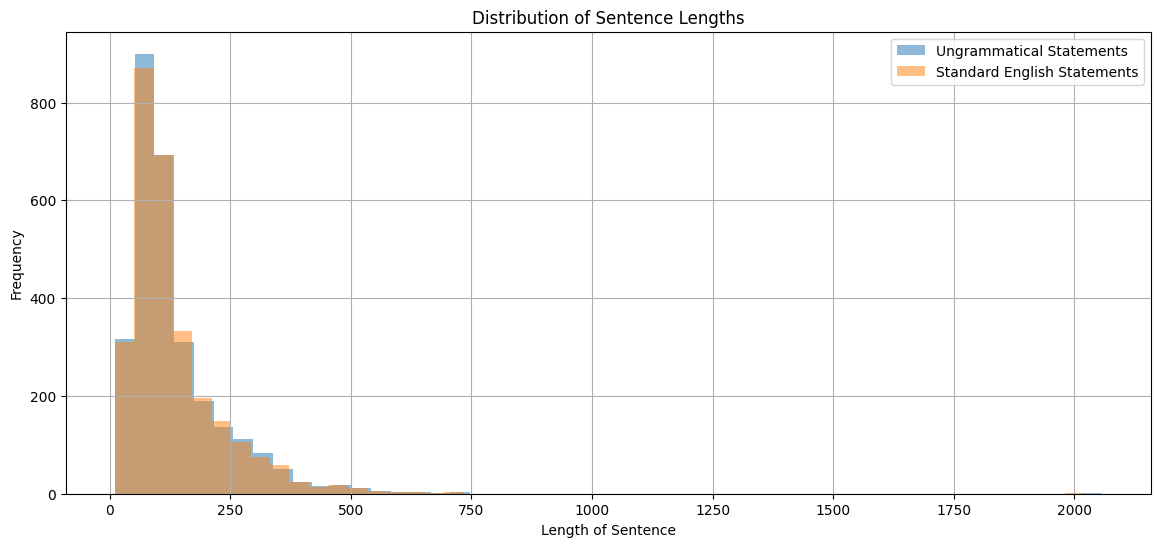

In [28]:
def plot_sentence_length_distribution(sentences: pd.Series, corrections: pd.Series):
  """
  Plot the distribution of sentence lengths for grammatical and non-grammatical sentences.
  param: sentences: pd.Series for ungrammatical sentences
  param: corrections: pd.Series for grammatical sentences
  """

  plt.figure(figsize=(14, 6))
  plt.hist(sentences.str.len(), bins=50, alpha=0.5, label='Ungrammatical Statements')
  plt.hist(corrections.str.len(), bins=50, alpha=0.5, label='Standard English Statements')
  plt.title('Distribution of Sentence Lengths')
  plt.xlabel('Length of Sentence')
  plt.ylabel('Frequency')
  plt.legend()
  plt.grid(True)

  plt.show()

plot_sentence_length_distribution(df["sentence"], df["corrections"])

As observed, the ungrammatical and grammatical sentences have a very similar length distribution. This is expected, as most of the errors are minor, such as typos, which do not significantly alter the sentence length.

Word Frequency Analysis

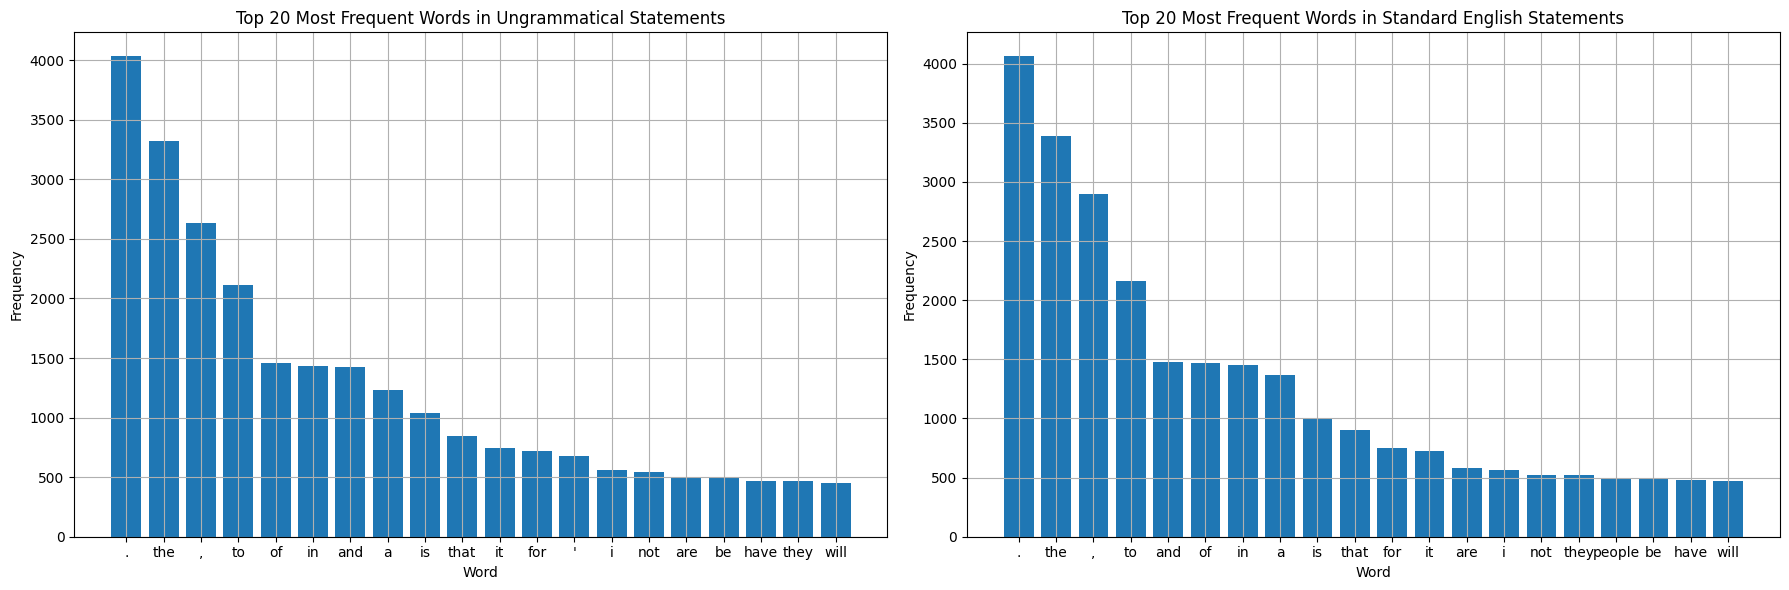

In [29]:
from collections import Counter
from nltk.tokenize import word_tokenize


def word_frequency(sentences: pd.Series, corrections: pd.Series):
    
    """
    Plot the distribution of words used for grammatical and non-grammatical sentences.
    param: sentences: pd.Series for ungrammatical sentences
    param: corrections: pd.Series for grammatical sentences
    """

    # Method to compute word frequency of a series of strings
    def compute_word_frequency(texts):
      words = []
      for text in texts:
        words.extend(word_tokenize(text.lower()))
      return Counter(words)

    # Compute word frequency for ungrammatical and grammatical sentences
    ungrammatical_word_freq = compute_word_frequency(sentences)
    grammatical_word_freq = compute_word_frequency(corrections)

    # plot the top 20 most frequent words side by side
    ungrammatical_word_freq_df = pd.DataFrame(ungrammatical_word_freq.most_common(20), columns=['Word', 'Frequency'])
    grammatical_word_freq_df = pd.DataFrame(grammatical_word_freq.most_common(20), columns=['Word', 'Frequency'])


    plt.figure(figsize=(18, 6))
    plt.subplot(1, 2, 1)
    plt.bar(ungrammatical_word_freq_df['Word'], ungrammatical_word_freq_df['Frequency'])
    plt.title('Top 20 Most Frequent Words in Ungrammatical Statements')
    plt.xlabel('Word')
    plt.grid()
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.bar(grammatical_word_freq_df['Word'], grammatical_word_freq_df['Frequency'])
    plt.title('Top 20 Most Frequent Words in Standard English Statements')
    plt.xlabel('Word')
    plt.ylabel('Frequency')
    plt.grid()
    plt.tight_layout()
    plt.show()

word_frequency(df["sentence"], df["corrections"])


As seen in the plots, the word "and" appears slightly more frequently in grammatical sentences compared to ungrammatical ones. Additionally, the apostrophe (" ' ") is notably common in ungrammatical sentences, ranking among the top 20 most frequent words, whereas it does not appear in the top 20 for grammatical sentences. This suggests that ungrammatical sentences might include more contractions or possessive forms, potentially leading to errors in punctuation or sentence structure.

POS tagging

In [30]:
from nltk import pos_tag

nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

<Figure size 3000x1000 with 0 Axes>

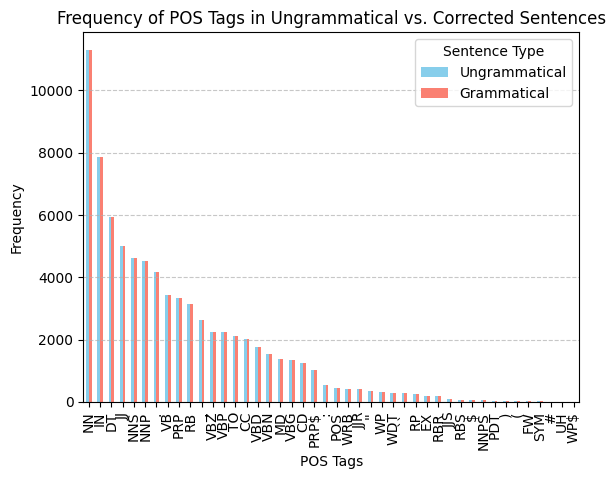

In [31]:
def pos_tag_distributions(sentences: pd.Series, corrections: pd.Series):

    # Method to compute pos tagging on a series of strings
    def pos_tagging(texts):
        tagged_sentences = []
        for sentence in sentences:
            tokens = word_tokenize(sentence)
            tagged = pos_tag(tokens)
            tagged_sentences.extend(tagged)
        return tagged_sentences

    # Compute pos tagging for ungrammatical and grammatical sentences
    pos_tag_ungrammatical = pos_tagging(sentences)
    pos_tag_grammatical = pos_tagging(corrections)

    # Count the frequency of each POS tag
    ungrammatical_pos_counts = pd.Series([tag for _, tag in pos_tag_ungrammatical]).value_counts()
    corrected_pos_counts = pd.Series([tag for _, tag in pos_tag_grammatical]).value_counts()

    # Convert to DataFrame for visualization
    pos_df = pd.DataFrame({
        'Ungrammatical': ungrammatical_pos_counts,
        'Grammatical': corrected_pos_counts
    }).fillna(0)

    # Plot
    plt.figure(figsize=(30, 10))
    pos_df.plot(kind='bar', color=['skyblue', 'salmon'])
    plt.title('Frequency of POS Tags in Ungrammatical vs. Corrected Sentences')
    plt.xlabel('POS Tags')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)  # Rotate the labels vertically
    plt.legend(title='Sentence Type')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

pos_tag_distributions(df["sentence"], df["corrections"])

Error Correction Difficulty Index

I decided to compute an error correction difficulty index by calculating the Levenshtein distance between the grammatical and ungrammatical sentences. This provides an indication of how challenging it might be to correct each sentence.

In [32]:
import numpy as np
from Levenshtein import distance as levenshtein_distance
import swifter

def difficulty_index(ungrammatical: str, corrected: str):
    """
    Compute the difficulty index of a corrected sentence compared to an ungrammatical sentence.
    param: ungrammatical: str for ungrammatical sentence
    param: corrected: str for grammatical sentence
    return: float between 0 and 1, where 1 is the most difficult and 0 is the easiest.
    """

    edit_distance = levenshtein_distance(ungrammatical, corrected)
    normalized_distance = edit_distance / max(len(ungrammatical), len(corrected))

    return normalized_distance

df['difficulty_index'] = df.swifter.apply(lambda row: difficulty_index(row['sentence'], row['corrections']), axis=1)
df.head()


Pandas Apply:   0%|          | 0/2879 [00:00<?, ?it/s]

,sentence,corrections,difficulty_index
0,New and new technology has been introduced to the society.,New technology has been introduced to society.,0.206897
1,New and new technology has been introduced to the society.,New technology has been introduced into the society.,0.172414
2,New and new technology has been introduced to the society.,Newer and newer technology has been introduced into society.,0.150000
3,New and new technology has been introduced to the society.,Newer and newer technology has been introduced to the society.,0.064516
4,One possible outcome is that an environmentally-induced reduction in motorization levels in the richer countries will outweigh any rise in motorization levels in the poorer countries.,One possible outcome is that an environmentally-induced reduction in motorization levels in richer countries will outweigh any rise in motorization levels in poorer countries.,0.043716


In [33]:
# reverse explode of the dataframe, 
# groupby sentences and add all the corrections to a list, average the difficulty index column
df = df.groupby(['sentence']).agg({'corrections': lambda x: list(x), 'difficulty_index': 'mean'}).reset_index()
df.head()

,sentence,corrections,difficulty_index
0,""" /It just doesn ' t wash, "" foreman tells ABC. "" We couldn't ' t allow ourselves to te emotionañ, "" William Zervakos says. He sais Travis Alexander abused Jodi Arias. "" Is thats am skiuse? Of course ot, "" he sais.","[""It just doesn't wash,"" foreman tells ABC. ""We couldn't allow ourselves to be emotional,"" William Zervakos says. He says Travis Alexander abused Jodi Arias. ""Is that an excuse? Of course not,"" he says.]",0.107477
1,""" He has brought shame on our family, "" says suspect ' s sister. "" I don ' t consider Atta Ullah my brother any more, "" she adds. The 23 - year - old student is being sought in connection wktM the attack on MQ:ala.","[""He has brought shame on our family,"" says suspect's sister. ""I don't consider Atta Ullah my brother any more,"" she adds. The 23-year-old student is being sought in connection with the attack on Malala.]",0.074766
2,""" I understand that it has taken hold, "" Israel ' s U. S. ambassador says of cease - fire. Israel alleges violations of the hours - old cease - fire; one official says five, another 12. U. N. ' s Ban Ki - moon says "" disproportionate "" use of fo$cW is "" intolerable. Agreement calls for "" total cessation of all Bostil$ activity "" from Gaza.","[""I understand that it has taken hold,"" Israel's U.S. ambassador says of cease-fire. Israel alleges violations of the hours-old cease-fire; one official says five, another 12. U.N.'s Ban Ki-moon says ""disproportionate"" use of force is ""intolerable. Agreement calls for ""total cessation of all hostile activity"" from Gaza.]",0.073314
3,""" Madden NFL 11 "" streamlines decision - making for a faster virtual gridiron experience. Handheld gaming enthusiasts have it good thanks to titles like "" Puzzle Quest 2 "" Sci - fi fans should also have a look at "" Transformer: War for Cybertron "" on the PC.","[""Madden NFL 11"" streamlines decision-making for a faster virtual gridiron experience. Handheld gaming enthusiasts have it good thanks to titles like ""Puzzle Quest 2"" Sci-fi fans should also have a look at ""Transformers: War for Cybertron"" on the PC.]",0.042636
4,"' Castumbul Castle is oon the market for that firest time every - a stunding properity, constructed between 2000 and 2008. The hope features gargoyles, suits o armours, gold wallpaper and curtains from Princess Diana ' s estate. It is just 35 minutes froom Adelaide ' S CBD, with handpainted ceilings, a decadent cellar and incredible home cinema.","['Castumbul Castle is on the market for the first time ever - a stunning property, constructed between 2000 and 2008. The home features gargoyles, suits of armours, gold wallpaper and curtains from Princess Diana's estate. It is just 35 minutes from Adelaide's CBD, with handpainted ceilings, a decadent cellar and incredible home cinema.]",0.046110


To accelerate the computation of the LLM, I decided to sort the sentences in the dataframe by length. This approach minimizes padding during batch processing, as transformer models pad sentences to the same length within a batch. By reducing the variability in sentence lengths, I can decrease unnecessary padding, leading to faster computation times.

In [34]:
# compute sentence length and sort by length, helpful for smart batching
df['sentence_length'] = df['sentence'].str.len()
df = df.sort_values(by='sentence_length')
df.head(10)

,sentence,corrections,difficulty_index,sentence_length
1206,it is ture.,[It is true.],0.272727,11
894,That`s turth !,"[That 's the truth !, That 's truth !]",0.317544,14
1104,We can use it.,[We can use it.],0.000000,14
522,It 's expensive.,[It 's expensive.],0.000000,16
119,Becaus we need food.,[Because we need food.],0.047619,20
844,So what shall I do ?,[So what shall I do ?],0.000000,20
456,If I have one sujest.,"[If I may, I have one suggestion., I have one suggestion., If I have one suggestion.]",0.312879,21
1134,Why do we like this ?,[Why do we like this ?],0.000000,21
886,That 's the way it is.,[That 's the way it is.],0.000000,22
523,It 's not really good.,"[It 's not really good., It 's not very good.]",0.090909,22


In [35]:
# after some analysis, some sentences may be not modified correctly
len(df[df["difficulty_index"]==0])

34

In [36]:
df = df[df["difficulty_index"] != 0]


# Model Corrections

In [ ]:
# reduce df to 100 examples
df_short = df.sample(10)
len(df_short)

In [ ]:
df_short = df_short.sort_values(by='sentence_length')

In [37]:
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

In [ ]:
%%time
#https://huggingface.co/vennify/t5-base-grammar-correction?library=transformers

model_name = "vennify/t5-base-grammar-correction"

# Load t5 model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# Function to generate corrections
def t5_corrections(sentences, batch_size):
    corrected_sentences = []
    for i in tqdm(range(0, len(sentences), batch_size)):
        
        batch = sentences[i:i+batch_size] # take a batch of sentences

        input_texts = ["grammar: " + sentence for sentence in batch]
        inputs = tokenizer(input_texts, return_tensors="pt", padding=True, truncation=True, max_length=512)

        # Generate corrections for the entire batch
        outputs = model.generate(**inputs, max_length=512, num_beams=4, early_stopping=True)

        # Decode all the generated sentences in the batch
        batch_corrected = tokenizer.batch_decode(outputs, skip_special_tokens=True)

        # Append the batch results to the final list
        corrected_sentences.extend(batch_corrected)

    return corrected_sentences

# Apply the model to each sentence and store the correction in a new column
df['t5_corrections'] = t5_corrections(df['sentence'].tolist(), batch_size=16)

cols = ["t5_corrections"]

 84%|████████▍ | 64/76 [15:03<06:47, 33.96s/it]

In [ ]:
df[['sentence', 't5_corrections', 'corrections']]

In [ ]:
%%time
# downloaded here https://huggingface.co/prithivida/grammar_error_correcter_v1?library=transformers


from transformers import T5ForConditionalGeneration

model_name = "grammarly/coedit-large"

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

# Function to generate corrections
def grammarly_corrections(sentences, batch_size):
    corrected_sentences = []
    for i in tqdm(range(0, len(sentences), batch_size)):
        
        batch = sentences[i:i+batch_size] # take a batch of sentences

        input_texts = ["Fix grammatical errors in this sentence: " + sentence for sentence in batch]
        inputs = tokenizer(input_texts, return_tensors="pt", padding=True, truncation=True, max_length=512)

        # Generate corrections for the entire batch
        outputs = model.generate(**inputs, max_length=512, num_beams=4, early_stopping=True)

        # Decode all the generated sentences in the batch
        batch_corrected = tokenizer.batch_decode(outputs, skip_special_tokens=True)

        # Append the batch results to the final list
        corrected_sentences.extend(batch_corrected)

    return corrected_sentences

# Apply the model to each sentence and store the correction in a new column
df['grammarly_corrections'] = grammarly_corrections(df['sentence'].tolist(), batch_size=16)

cols.append("grammarly_corrections")

In [ ]:
df_short[['sentence', 't5_corrections', 'grammarly_corrections', 'corrections']]

In [ ]:
df_short[['sentence', 't5_corrections', 'grammarly_corrections', 'corrections']]

In [ ]:
%%time
# downloaded here https://huggingface.co/MRNH/mbart-english-grammar-corrector

model_name = "MRNH/mbart-english-grammar-corrector"

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# Function to generate corrections
def mbart(sentences, batch_size):
    corrected_sentences = []
    for i in tqdm(range(0, len(sentences), batch_size)):
        
        batch = sentences[i:i+batch_size] # take a batch of sentences
        
        # qui sembra che non ci sia bisogno di "grammar:"
        input_texts = [sentence for sentence in batch]
        inputs = tokenizer(input_texts, return_tensors="pt", padding=True, truncation=True, max_length=512)

        # Generate corrections for the entire batch
        outputs = model.generate(**inputs, max_length=512, num_beams=4, early_stopping=True)

        # Decode all the generated sentences in the batch
        batch_corrected = tokenizer.batch_decode(outputs, skip_special_tokens=True)

        # Append the batch results to the final list
        corrected_sentences.extend(batch_corrected)

    return corrected_sentences

# Apply the model to each sentence and store the correction in a new column
df_short['mbart_corrections'] = mbart(df_short['sentence'].tolist(), batch_size=16)

cols.append("mbart_corrections")

In [ ]:
df_short[['sentence', 't5_corrections', 'grammarly_corrections', 'mbart_corrections', 'corrections']]

In [ ]:
%%time

import spacy
import contextualSpellCheck

nlp = spacy.load('en_core_web_sm')
contextualSpellCheck.add_to_pipe(nlp)

def spacy_corrections(ungrammatical: str):
    """
    Compute 
    
    """
    doc = nlp(ungrammatical)
    return doc._.outcome_spellCheck

# Apply the model to each sentence and store the correction in a new column
df_short['spacy_corrections'] = df_short.swifter.apply(lambda row: spacy_corrections(row['sentence']), axis=1)
cols.append("spacy_corrections")
df_short.head()


# Evaluation

In [ ]:
!pip install sacrebleu

In [ ]:
df_short = df_short.explode(column="corrections")

In [ ]:
import sacrebleu

def compute_bleu(predictions, references):
    print(predictions)
    print(references)
    return sacrebleu.corpus_bleu(predictions, [references]).score

for c in cols:
    col_name = c+" bleu_score"
    df_short[col_name] = df_short.swifter.apply(lambda row: compute_bleu([row[c]], [row['corrections']]), axis=1)

df_short.head(2) 

In [ ]:
df_short.head(2)

In [ ]:
for c in cols:
    name = c+" bleu_score"
    s = df_short[name].mean()
    print(f"Average {name}: {s}")

# Post Analysis

In [ ]:
import errant

annotator = errant.load('en')
nlp = spacy.load("en_core_web_sm")

# Function to get error types using ERRANT
def get_error_types(sentence, correction):
    orig = nlp(sentence)
    cor = nlp(correction)
    
    # Align the original and corrected sentence to detect errors
    alignment = annotator.annotate(orig, cor)
    # Extract the error types (e.g., VERB:TENSE, NOUN:NUM)
    error_types = [error.type for error in alignment]
    return error_types

# Apply the function to each row
df_short['sentence_error_type'] = df_short.swifter.apply(lambda row: get_error_types(row['sentence'], row['corrections']), axis=1)

for c in cols:
    col_name = c+"_error_type"
    df_short[col_name] = df_short.swifter.apply(lambda row: get_error_types(row[c], row['corrections']), axis=1)

df_short.head(2)

In [ ]:
def plot_errors_distribution(df, sentence, correction):
    """
    param: df
    param: sentence col name of the sentence with errors
    param: correction col name of the corrected sentence

    """
    
    # Step 1: Flatten the list of error types into a single column
    df_correction_flat = df.explode(correction)
    df_sentence_flat = df.explode(sentence)

    # Step 2: Count the occurrences of each error type
    corrections_error_type_counts = df_correction_flat[correction].value_counts()
    sentences_error_type_counts = df_sentence_flat[sentence].value_counts()
    
    
    # Step 3: Combine the counts into a single dataframe for comparison
    error_comparison_df = pd.DataFrame({
        'correction_errors': corrections_error_type_counts,
        'sentence_errors': sentences_error_type_counts
    }).fillna(0)  # Fill NaNs with 0 for types that may not exist in both columns
    
    # Plot
    plt.figure(figsize=(30, 10))
    error_comparison_df.plot(kind='bar', color=['skyblue', 'salmon'])
    plt.title('Frequency of Errors')
    plt.xlabel('Errors')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)  # Rotate the labels vertically
    plt.legend(title='Errors2')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    
plot_errors_distribution(df_short, "sentence_error_type", "t5_corrections_error_type")